:white_check_mark: **Finding the chessboard**

Write a program, that takes a folder of pictures, finds chessboard in every picture, and either draws the chessboard or reports that it could not find one.

You will find the following functions helpful:

- [`cv2.findChessboardCorners`](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) - finding chessboard corners (returns series of floats)
  - Please note that parameter `patternSize` expects number of corners between checkers, e.g. 8x5 with 9x6 checkerboard
- [`cv2.cornerSubPix`](https://docs.opencv.org/4.8.0/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e) - more exact corner positions
- [`cv2.drawChessboardCorners`](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022) - drawing chessboard corners on the image

Function `cv2.cornerSubPix` expects five parameters:

- image, note that it is required for the image to be single channel, so conversion using `cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)` is necessary,
- corners detected by `findChessboardCorners`,
- half of the side length of the search window (we suggest `(11,11)`),
- half of the size of the dead region in the middle of the search zone (we suggest `(-1, -1)` meaning no zone),
- criteria for termination of the iterative process of corner refinement (we suggest: `criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)`).

Example output:
![Chessboard](chessboard_found.png)


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

PATTERN_SIZE = (8, 5)


def cv2_imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


def find_chessboards(images_dir: str):

    for file in os.listdir(images_dir):
        img = cv2.imread(f"./{images_dir}/{file}")

        result, corners = cv2.findChessboardCorners(img, PATTERN_SIZE)

        img_to_draw = img.copy()
        cv2.drawChessboardCorners(img_to_draw, PATTERN_SIZE, corners, result)
        cv2_imshow(img_to_draw)


find_chessboards("data")

:white_check_mark: **Camera calibration**

Now we will expand the program to find:

- estimates of the rotation and translation vectors for each pattern view
- intrinsic parameters for the camera together with the distortion coefficients

For that purpose, we will use the function
[`cv2.calibrateCamera`](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d).
Let's have a closer look at the function parameters.

First, note that `calibrateCamera` takes `cameraMatrix` and `distCoeffs` as arguments, even though we want to find them.
If available, the function utilizes the initial values provided for these arguments during computation.
In our case, we don't have any initial guesses.
Hence, we can simply use:

```python
cameraMatrix = None, distCoeffs = None
```

Second, you have to provide an array of `objpoints` (3D) as arguments to the `calibrateCamera`.
This is actually the core part of the task.
You should write a function that will output object points when provided with the checker width and the number of corners (vertically and horizontally) on the chessboard.

For example for a 4x5 chessboard with 30mm squares the output could look like `(0,0,0), (30,0,0), (60,0,0), ....,(90,60,0)`.
In this example the unit we used for `objpoints` was millimeters.
Note that if we have 4x5 chessboard there are 3x4 intersection corners between checkers,
so with our 9x6 calibration checkerboard you should generate 8x5=40 object points.

Hints:

- `objpoints` should have type `np.float32` (the default of `np.float64` will not work).
- `np.mgrid()` is a nice numpy function you may want to use.


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

PATTERN_SIZE = (8, 5)
CRITERIA = (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 30, 0.001)


def cv2_imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


def find_object_points(checker_width: float, corners_num: tuple[float, float]):
    obj_points = np.zeros((corners_num[0] * corners_num[1], 3), np.float32)
    obj_points[:, :2] = checker_width * np.mgrid[
        0 : corners_num[0], 0 : corners_num[1]
    ].T.reshape(-1, 2)

    return obj_points


obj_points = find_object_points(30, PATTERN_SIZE)
img_points = []

for file in os.listdir("data"):
    img = cv2.imread(f"./data/{file}")

    result, corners = cv2.findChessboardCorners(img, PATTERN_SIZE)

    if result:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        corners_ref = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), CRITERIA)
        img_points.append(corners_ref)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    [obj_points for _ in range(len(img_points))], img_points, img.shape[:-1], None, None
)

:white_check_mark: **Undistort images**

Now that we have our camera calibrated we can undistort the images.
Your goal now is to write a program that reads images
and shows both distorted (original) and undistorted images next to each other.

We could use
[`cv2.undistort`](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d) function to simply undistort the images.
However it is much faster to compute the undistortion and rectification transformation map using
[`cv2.initUndistortRectifyMap`](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga7dfb72c9cf9780a347fbe3d1c47e5d5a)
and then reuse these maps multiple times with
[`cv2.remap`](https://docs.opencv.org/4.8.0/da/d54/group__imgproc__transform.html#gab75ef31ce5cdfb5c44b6da5f3b908ea4).

You can use the following values for some of the parameters of `cv2.initUndistortRectifyMap` and `cv2.remap`:

```python
R = np.eye(3), m1type=cv2.CV_32FC1, interpolation=cv2.INTER_LINEAR
```

Take a look at
`cv2.initUndistortRectifyMap()` documentation for mathematical details.
As a reminder from lab2
[`cv2.getOptimalNewCameraMatrix()`](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga7a6c4e032c97f03ba747966e6ad862b1)
can be useful and `alpha` parameter should be chosen so that desired behaviour is achieved.
You have to decide if it is better to retain all pixels or work with a smaller field of view.


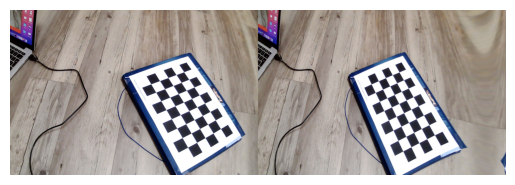

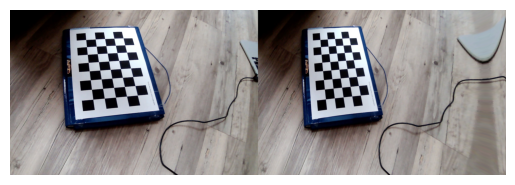

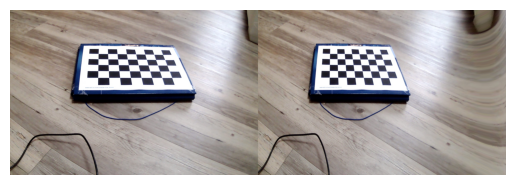

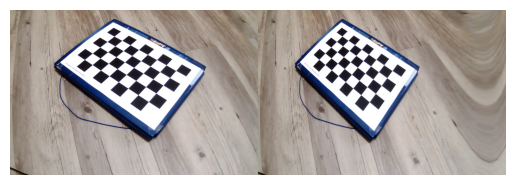

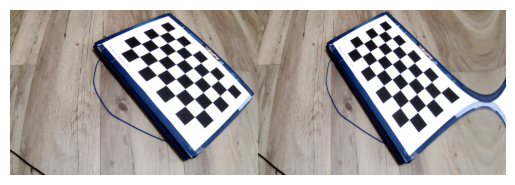

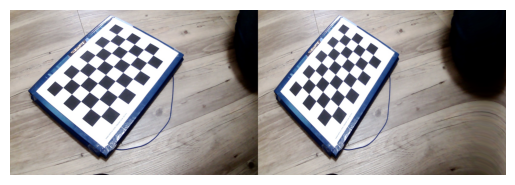

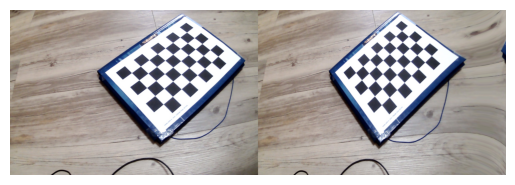

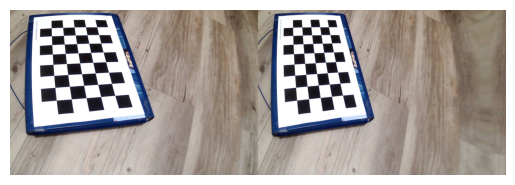

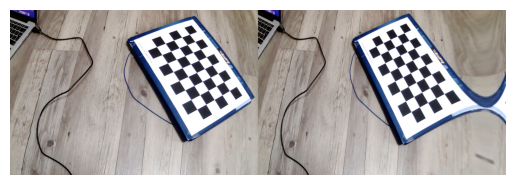

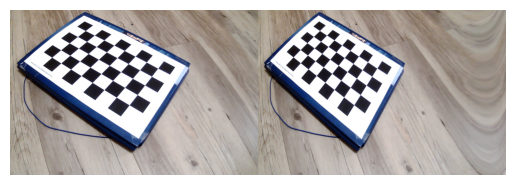

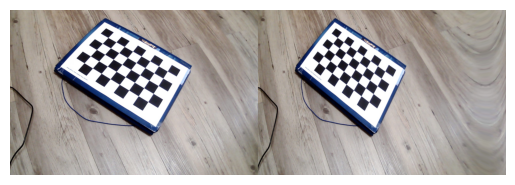

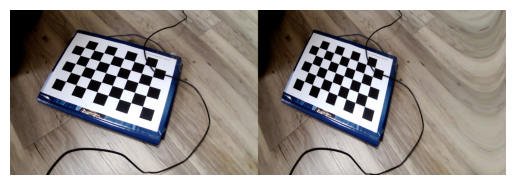

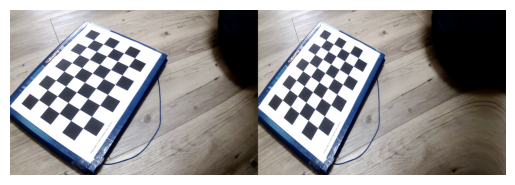

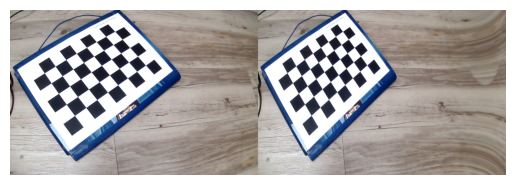

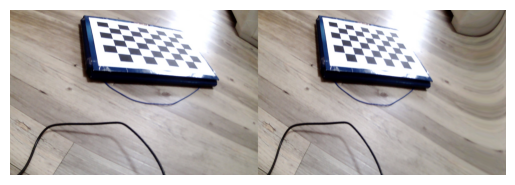

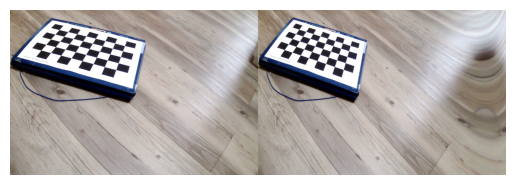

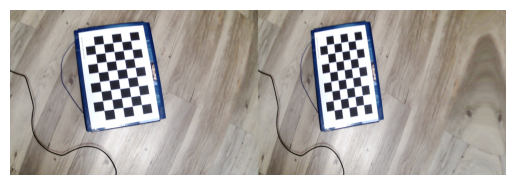

In [ ]:
size = (img.shape[1], img.shape[0])

new_mtx, _ = cv2.getOptimalNewCameraMatrix(mtx, dist, size, 0)

map1, map2 = cv2.initUndistortRectifyMap(
    mtx, dist, np.eye(3), new_mtx, size, cv2.CV_32FC1
)

for file in os.listdir("data"):
    img = cv2.imread(f"./data/{file}")
    rect_img = cv2.remap(img, map1, map2, cv2.INTER_LINEAR)
    cv2_imshow(cv2.hconcat([img, rect_img]))